# DeepTrack 2.1 - Loading external data

This tutorial gives an overview of how to load external data into DeepTrack 2.1. We'll use a malaria classification dataset as an example.

In [1]:
import deeptrack as dt
import matplotlib.pyplot as plt
import numpy as np
u = dt.units

## 1. Downloading the dataset

For convenience, we will download the data using torchvision. The dataset is available at [https://lhncbc.nlm.nih.gov/publication/pub9932.](https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip)


In [2]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "blood_smears_dataset")
if not os.path.exists(dataset_path):
    url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
    download_url(url, ".")
    _extract_zip("cell_images.zip", dataset_path, None)
    os.remove("cell_images.zip")

## 2. Discovering the dataset

Next, we will discover the dataset using `DeepTrack` `Source`s. `Source`s complement `Feature`s by providing metadata about the data to be processed. Here, we will create a Source object containing all the files in the dataset.

In [3]:
files = dt.sources.ImageFolder(root=os.path.join(dataset_path, "cell_images"))
print(f"Dataset contains {len(files)} images")

Dataset contains 27558 images


The `ImageFolder` object contains three items that can be pulled by `Feature`s: `path`, `label`, and `label_name`. We can inspect the first item of the dataset to see what these look like.

In [4]:
files[0]

SourceItem({'path': '.\\blood_smears_dataset\\cell_images\\Parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png', 'label': 0, 'label_name': 'Parasitized'})

We see that the `path` is the path to the file, `label` is the class of the image, and `label_name` is the name of the class.

### 2.1. Combining sources with features

Sources are provided as arguments when creating a feature. Once created, you can call resolve (`call`) the feature with an item of the `Source` to get the value of the feature for that item. First, let's show this for loading an image.

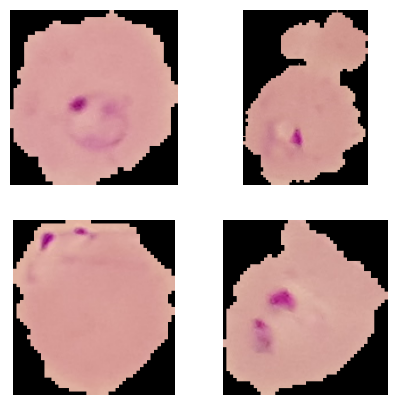

In [5]:
loader = dt.LoadImage(path=files.path)

fig, ax = plt.subplots(2, 2, figsize=(5, 5))

for ax, file in zip(ax.flatten(), files):
    image = loader(file)
    ax.imshow(image)
    ax.axis("off")

Next, we can extract the label, which will the target of the classification task.

In [6]:
label_pipeline = dt.Value(value=files.label)

Let's combine all this knowledge to create a data pipeline for image classification:

In [7]:
loader_pipeline = (
    loader 
    >> dt.Resize((32, 32))
    >> dt.Divide(255)
)

data_pipeline = loader_pipeline & label_pipeline

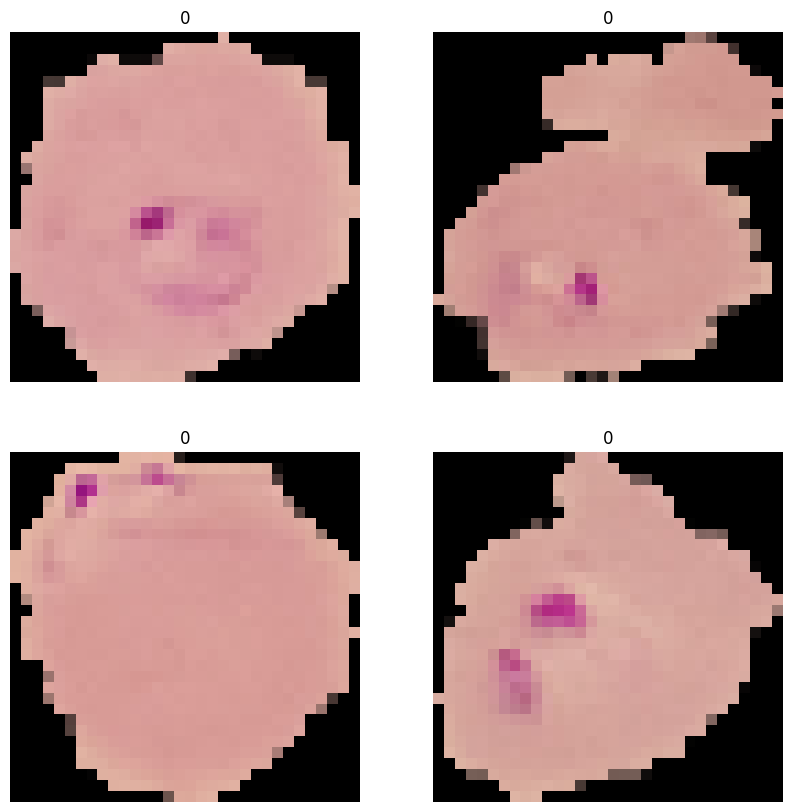

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for ax, file in zip(ax.flatten(), files):
    image, y = data_pipeline.update()(file)
    ax.imshow(image)
    ax.set_title(y)
    ax.axis("off")

# 3.1 Creating a dataset

To work with the data, we will need to create a `Dataset` object. This will allow us to easily access the data and use it to train a model. Note, we set `permute_channels` to `True` to convert the images from channels-last to channels-first format, which is the format expected by Deeplay and PyTorch.

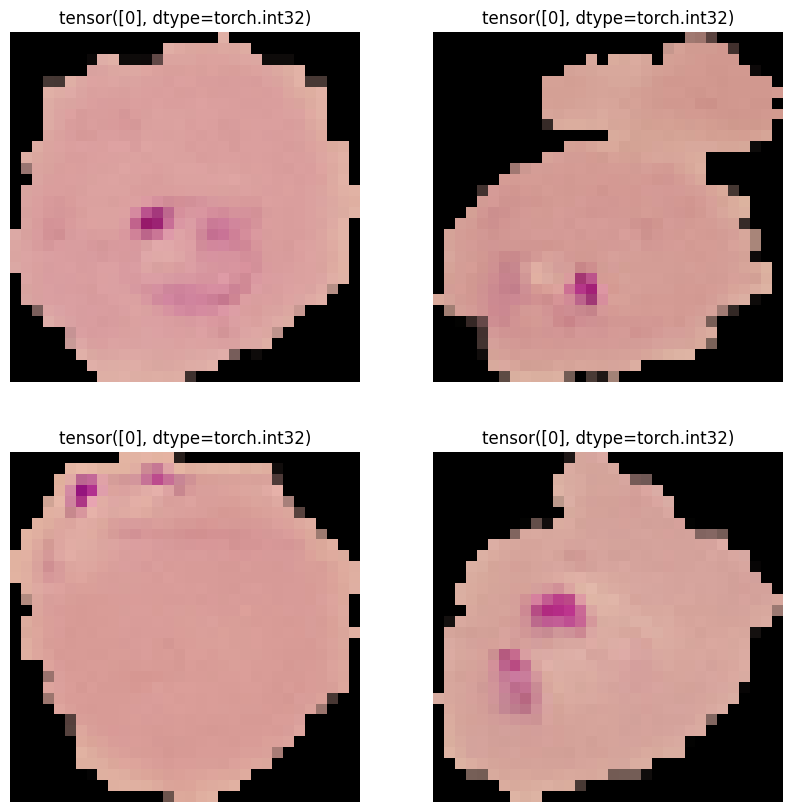

In [9]:
dataset = dt.pytorch.Dataset(data_pipeline, files, permute_channels=True)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for ax, (image, label) in zip(ax.flatten(), dataset):
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(label)
    ax.axis("off")

## 3.2. Training and validation sets

This dataset is a subclass of pytorch's `Dataset` class, which allows us to easily split the data into training and validation sets. We can then use these sets to train and validate a model.

In [10]:
import torch
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])

## 4.1 Training

With the dataset ready, we can now train a model. We will use a simple convolutional neural network with two convolutional layers and two fully connected layers. We will use the Adam optimizer and the cross-entropy loss function.

In [11]:
import deeptrack.deeplay as dl

model = dl.Sequential(
    # Convolutional encoder
    dl.ConvolutionalEncoder2d(3, [32], 64),
    # Global average pooling ((w, h) -> (1, 1))
    torch.nn.AdaptiveMaxPool2d((1, 1)),
    # Fully connected layer
    dl.MultiLayerPerceptron(64, [32], 1, 
                            out_activation=torch.nn.Sigmoid())
)

# Set the model loss and optimizer
model = dl.Model(model,
                 train_data=train,
                 val_data=test,
                 loss=torch.nn.BCELoss(),
                 optimizer=dl.Adam(lr=1e-3))

model

optimizer is an instance of Optimizer


Model(
  (loss): BCELoss()
  (optimizer): Adam[Adam](lr=0.001)
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): PoolLayerActivationNormalization(
          (pool): Layer[Identity]()
          (layer): Layer[Conv2d](in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
          (activation): Layer[ReLU]()
          (normalization): Layer[Identity](num_features=32)
        )
        (1): PoolLayerActivationNormalization(
          (pool): Layer[MaxPool2d](kernel_size=2)
          (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
          (activation): Layer[ReLU]()
          (normalization): Layer[Identity](num_features=64)
        )
      )
      (postprocess): Layer[Identity]()
    )
    (1): AdaptiveMaxPool2d(output_

In [14]:
model.fit(max_epochs=10, batch_size=32, val_batch_size=128)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | BCELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 21.5 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
21.5 K    Trainable params
0         Non-trainable params
21.5 K    Total params
0.086     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | BCELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | Me

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


We can use torchmetrics to easily calculate the accuracy of the model

In [17]:
import torchmetrics as tm

accuracy = tm.Accuracy(task="binary")
results = model.test(test, metrics={"accuracy": accuracy})
print(f"Test accuracy: {results['accuracy'] * 100:.2f}%")

100%|██████████| 173/173 [00:00<00:00, 310.04it/s]

Test accuracy: 95.57%
